# Multigrid

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 
This page also contains figures from Krzysztof Fidkowski's CFD course notes.

In [6]:
import time
import jax
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import solve

import matplotlib.pyplot as plt
# import niceplots

# plt.style.use(niceplots.get_style())
# niceColors = niceplots.get_colors_list()

# Force the jupyter notebook to use vector graphics
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

In this problem we're going to solve the same 1D heat transfer problem as the past 2 weeks' example, this time using multigrid.

First let's redefine the problem and some of the functions we used to iteratively solve it

In [7]:
# Define the parameters
L = 2.0  # Length of domain
kappa = 0.5  # Thermal conductivity
Nx = 64  # Number of intervals
T0 = 1.0  # Left boundary condition
TN = 4.0  # Right boundary condition
tol = 1e-6  # Tolerance for iterative solver


# Define the symbolic function q(x)
def q(x, L):
    return np.sin(np.pi * x / L)


def computeResidual(u, q, kappa, dx):
    """Compute the residual of the 1D heat equation

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing

    Returns
    -------
    numpy.ndarray
        Residual vector
    """
    dx2 = dx**2
    r = np.zeros_like(u)
    r[1:-1] = kappa * (u[:-2] - 2 * u[1:-1] + u[2:]) / dx2 + q[1:-1]

    return r


def computeNorm(r):
    """Compute the "normalized" norm of a vector

    Parameters
    ----------
    r : numpy.ndarray
        Vector to compute the norm of
    """
    return np.linalg.norm(r) / np.sqrt(len(r))


def iterativeSolve(u, q, kappa, dx, smootherFunc, omega=1.0, tol=1e-4, maxIter=5000):
    """Iteratively solve the steady-state 1D heat equation

    Parameters
    ----------
    u : numpy ndarray
        Initial state
    q : numpy ndarray
        Right-hand side
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    smootherFunc : function with signature f(u, q, kappa, dx, omega=1.0))
        Function that performs a single smoothing iteration
    omega : float, optional
        Relaxation factor, by default 1.0
    tol : float, optional
        Residual norm to stop at, by default 1e-4
    maxIter : int, optional
        Maximum number of iterations, by default 5000

    Returns
    -------
    numpy ndarray
        New state
    """
    resNormHistory = []
    iterationTimes = []
    printFrequency = max(1, maxIter // 10)
    startTime = time.time()
    for ii in range(maxIter):
        r = computeResidual(u, q, kappa, dx)
        resNorm = computeNorm(r)
        if ii % printFrequency == 0:
            print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
        resNormHistory.append(resNorm)
        iterationTimes.append(time.time() - startTime)
        if resNorm < tol or resNorm > 1e10 or np.isnan(resNorm):
            break
        u = smootherFunc(u, q, kappa, dx, omega=omega)

    if ii % printFrequency != 0:
        print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
    return u, resNormHistory, iterationTimes


def gaussSeidelIteration(u, q, kappa, dx, omega=1.0):
    """Perform one Gauss-Seidel smoothing step

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    omega : float, optional
        Relaxation factor, by default 1.0

    Returns
    -------
    numpy.ndarray
        Updated state vector
    """
    dx2k = dx**2 / kappa
    uNew = u.copy()
    for ii in range(1, len(u) - 1):
        uNew[ii] = omega * (0.5 * (uNew[ii - 1] + uNew[ii + 1] + q[ii] * dx2k)) + (1.0 - omega) * uNew[ii]
    return uNew

The effectiveness of multigrid depends on two things:
- Iterative smoothers require fewer iterations when started from a good initial guess
- Iterative smoothers reduce high frequency errors faster than low frequency errors

Let's demonstrate these 2 points, first by solving the problem starting from a bad initial guess ($T=0$ everywhere) and then by solving the problem starting from a good initial guess ($T$ varying linearly between the boundaries).

In [8]:
T_init_good = np.linspace(T0, TN, Nx + 1)
T_init_bad = np.copy(T_init_good)
T_init_bad[1:-1] = 0.0

x = np.linspace(0, L, Nx + 1)
q_array = q(x, L)

T_sol_bad, res_history_bad, iter_times_bad = iterativeSolve(
    T_init_bad, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.4, tol=tol
)
T_sol_good, res_history_good, iter_times_good = iterativeSolve(
    T_init_good, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.4, tol=tol
)

Iteration 0: Res norm = 2.62e+02
Iteration 500: Res norm = 2.18e-01
Iteration 1000: Res norm = 1.30e-02
Iteration 1500: Res norm = 7.76e-04
Iteration 2000: Res norm = 4.63e-05
Iteration 2500: Res norm = 2.76e-06
Iteration 2680: Res norm = 9.99e-07
Iteration 0: Res norm = 7.02e-01
Iteration 500: Res norm = 4.24e-02
Iteration 1000: Res norm = 2.53e-03
Iteration 1500: Res norm = 1.51e-04
Iteration 2000: Res norm = 8.99e-06
Iteration 2390: Res norm = 9.97e-07


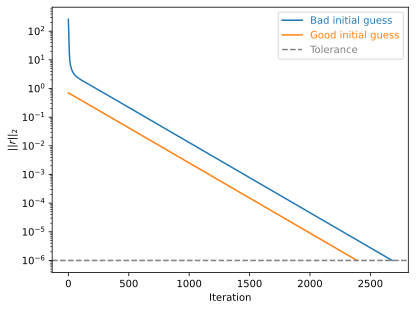

In [9]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("$||r||_2$")
ax.plot(res_history_bad, clip_on=False, label="Bad initial guess")
ax.plot(res_history_good, clip_on=False, label="Good initial guess")
ax.axhline(tol, color="Gray", linestyle="--", label="Tolerance")
ax.legend(labelcolor="linecolor")
# niceplots.adjust_spines(ax)

To demonstrate how different frequencies of error are reduced at different rates, we'll run 10 iterations starting from the true solution plus a high frequency error and then starting from the true solution plus a low frequency error.

Iteration 0: Res norm = 8.65e-03
Iteration 1: Res norm = 8.62e-03
Iteration 2: Res norm = 8.59e-03
Iteration 3: Res norm = 8.56e-03
Iteration 4: Res norm = 8.53e-03
Iteration 5: Res norm = 8.50e-03
Iteration 6: Res norm = 8.47e-03
Iteration 7: Res norm = 8.44e-03
Iteration 8: Res norm = 8.41e-03
Iteration 9: Res norm = 8.38e-03
Iteration 0: Res norm = 5.47e-01
Iteration 1: Res norm = 4.63e-01
Iteration 2: Res norm = 3.90e-01
Iteration 3: Res norm = 3.27e-01
Iteration 4: Res norm = 2.75e-01
Iteration 5: Res norm = 2.30e-01
Iteration 6: Res norm = 1.93e-01
Iteration 7: Res norm = 1.61e-01
Iteration 8: Res norm = 1.34e-01
Iteration 9: Res norm = 1.12e-01


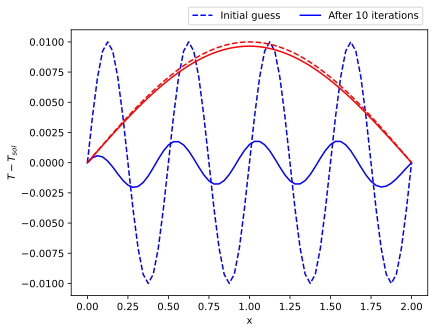

In [14]:
T_init_highfreq = T_sol_good + 0.01 * np.sin(8 * np.pi * x / L)
T_init_lowfreq = T_sol_good + 0.01 * np.sin(1 * np.pi * x / L)

T_sol_lowfreq, res_history_lowfreq, iter_times_lowfreq = iterativeSolve(
    T_init_lowfreq, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.2, tol=1e-14, maxIter=10
)
T_sol_highfreq, res_history_highfreq, iter_times_highfreq = iterativeSolve(
    T_init_highfreq, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.2, tol=1e-14, maxIter=10
)

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel(r"$T - T_{sol}$")
ax.plot(x, T_init_highfreq - T_sol_good, "--", color= 'blue', label="Initial guess", clip_on=False)
ax.plot(x, T_init_lowfreq - T_sol_good, "--",color= 'red', clip_on=False)
ax.plot(x, T_sol_highfreq - T_sol_good, color= 'blue',label="After 10 iterations", clip_on=False)
ax.plot(x, T_sol_lowfreq - T_sol_good,color= 'red', clip_on=False)
ax.legend(ncol=2, loc="lower right", bbox_to_anchor=(1.0, 1.0))
# niceplots.adjust_spines(ax)

## Implementing a basic 2-level multigrid solver

In this example we are going to implement a very simple 2-level multigrid smoother to use in out iterative solver algorithm.  Note that this is not a great implementation, it is hardcoded to use only 2 levels. In your next homework you will be given the task of implementing a more general multigrid solver that can use any number of levels.

A 2-level multigrid iteration consists of the following steps:
- Running $n_\text{pre}$ iterations of a smoother on the fine grid
- Restricting/averaging the residual to the coarse grid
- Running $n_\text{coarse}$ iterations of a smoother on the coarse grid
- Prolonging/interpolating the coarse grid correction to the fine grid
- Adding the fine grid correction to the solution
- Running $n_\text{post}$ iterations of a smoother on the fine grid

![Full weighting restriction](../../images/MultigridCycle.png)

It's important to recognise that the system of equations we are solving on the coarse grid is slightly different from the system we are solving on the fine grid. On the fine grid we are solving:

$$A_h T = q$$

Once we solve the system on the coarse grid, one thing we could do is just to interpolate the coarse grid solution back to the fine grid, overwriting whatever we had on the fine grid. However, this would not be a good idea as we would be throwing away information we had on the fine grid. Instead, we want to use the coarse grid to compute a **correction** to our fine grid solution. 

To help think about how to compute this correction, let's define the solution error:

$$e = T^* - T$$

where $T^*$ is the true solution and $T$ is our current approximation to the solution. Notice that if we knew what $e$ was, we could just add it to $T$ to get the true solution.

$$T + e = T + (T^* - T) = T^*$$

If we multiply the error by our finite difference matrix $A$, we get:

$$Ae = A(T^* - T) = AT^* - AT = q - AT = r$$

So on the coarse grid, we solve $Ae = r$ approximately. to find a correction $e$ that should take us closer to the true solution, $T^*$ on the coarse grid. Once we have this correction, we can interpolate it back to the fine grid and add it to our current approximation to the solution there.

In this implementation, our coarse grid is exactly a factor of 2 coarser that the fine grid, the stencils for the restriction and prolongation operators are therefore pretty simple, as shown below.
In more complex codes, it may not be possible generate such an ideal coarse grid and the restriction and prolongation may be more complex averaging/interpolation operations.

![Full weighting restriction](../../images/MultigridRestriction.png)

In [15]:
# Define residual restriction operator from fine grid to coarse grid using full-weighting
def restrict_to_coarse(u_fine):
    return 0.25 * u_fine[0:-2:2] + 0.5 * u_fine[1:-1:2] + 0.25 * u_fine[2::2]

![Prolongation](../../images/MultigridProlongation.png)

In [16]:
# Define prolongation operator from coarse grid to fine grid
def prolongate_to_fine(u_coarse):
    u_fine = jnp.zeros(2 * (len(u_coarse)-1) + 1)  # Create an empty fine grid
    # Assign values from coarse grid directly for even elements
    u_fine = u_fine.at[2:-2:2].set(u_coarse[1:-1])
    # Use weights 1/2 and 1/2 for odd elemenx ts
    u_fine = u_fine.at[1:-1:2].set(0.5 * (u_coarse[:-1] + u_coarse[1:]))

    return u_fine

We define the relaxed jacobi iteration wich will be used for pre-smoothing and post-smoothing.

In [17]:
def jacobi_iteration_with_relax(u, f, h, num_iterations, w=2./3):
    for _ in range(num_iterations):
        uNew = u.copy()
        uNew = uNew.at[1:u.shape[0]-1].set(jnp.array(0.5 * (u[:-2] + u[2:] + h**2 * f[1:-1])))
        u = w * uNew + (1-w)*u
    return u

Now we define the two grid V-cycle.

In [18]:
def two_grid_cycle(u, f, h, v1, v2):

    # Pre-smoothing
    u = jacobi_iteration_with_relax(u, f, h, v1)

    # Compute the residual on the fine grid
    residual = jnp.zeros_like(u)
    residual = residual.at[1:residual.shape[0]-1].set(f[1:-1] - -(u[0:-2] - 2 * u[1:-1] + u[2:]) / h**2)

    # Restrict the residual to the coarse grid
    coarse_residual = jnp.zeros(jnp.floor_divide(u.shape[0] - 1, 2)+1)
    coarse_residual = coarse_residual.at[1:coarse_residual.shape[0]-1].set(restrict_to_coarse(residual[1:-1]))

    # Solve the coarse grid problem recursively
    # Create the matrix A (tridiagonal with 2 on the diagonal and -1 on the off-diagonals)
    Nx = coarse_residual.shape[0]-1
    diagonal = 2.0 * jnp.ones(Nx - 1)
    off_diagonal = -jnp.ones(Nx - 2)
    A = jnp.diag(diagonal) + jnp.diag(off_diagonal, k=1) + jnp.diag(off_diagonal, k=-1)
    # Add the Boundary conditions
    A = jnp.vstack((A, jnp.zeros(Nx - 1)))
    A = jnp.vstack((jnp.zeros(Nx - 1), A))
    A = jnp.column_stack([jnp.zeros(A.shape[0]), A])
    A = jnp.column_stack([A, jnp.zeros(A.shape[0])])
    A = A.at[(0, 0)].set(1.0)
    A = A.at[(-1, -1)].set(1.0)  # Set the bottom-right diagonal element to 1
    A = A.at[(1, 0)].set(-1.0)
    A = A.at[(-2, -1)].set(-1.0)  # Set the bottom-right diagonal element to 1

    e_coarse = solve(A, (4*h**2) * coarse_residual)

    # Prolongate the error back to the fine grid
    e_fine = prolongate_to_fine(e_coarse)

    # Correct the fine grid solution
    u = u + e_fine

    # Post-smoothing
    u = jacobi_iteration_with_relax(u, f, h, v2)
    return u

In [19]:
# Define a simple Poisson problem (-u_xx = f) on the interval [0, 1]
def poisson_problem(N):
    h = 1.0 / (N)
    x = jnp.linspace(0, 1, N+1)
    f = jnp.zeros(N+1)  # Example right-hand side (modify as needed)
    u = jnp.sin(5 * jnp.pi * x) + jnp.sin(15 * jnp.pi * x)  # Initial guess
    plt.figure()
    plt.plot(u)
    return u, f, h

# Main function to solve the problem using two-grid cycle
def solve_poisson_multigrid(N, v1, v2, iterations):
    u, f, h = poisson_problem(N)
    error = jnp.zeros(iterations)
    for i in range(iterations):
      u = two_grid_cycle(u, f, h, v1, v2)
      error = error.at[i].set(jnp.linalg.norm(u))
      plt.plot(u, label='Iteration ' + str(i+1))
    return u, error

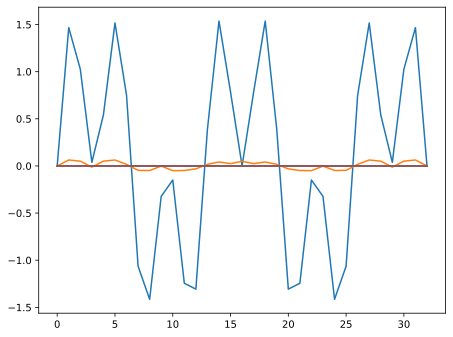

In [31]:
# Example usage:
N = 32  # Number of grid points
v1 = 2  # Pre-smoothing iterations
v2 = 1  # Post-smoothing iterations
N_iter = 15  # Number of grid-cycles
solution, error = solve_poisson_multigrid(N, v1, v2, N_iter)
# plt.legend(loc='right',bbox_to_anchor=(0,0))
plt.tight_layout()
plt.show()

This plot represents the solution for successive iterations : initial guess is in blue, first iteration is orange, etc. It happens that after few iterations the solution has converged to zero and iterations are overlayed. 

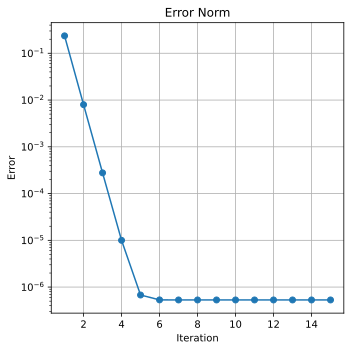

In [33]:
# Plot the error and convergence rate
plt.figure(figsize=(5, 5))
plt.plot(jnp.arange(1, N_iter+1), error, marker='o', label='Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error Norm')

plt.grid(True)
plt.tight_layout()
plt.show()

We can notice that the convergence rate is high : error is roughly divided by 10 at each iteration and we bottom at zero after 5 iterations. 